C:\Users\berkc\Miniconda3\envs\Research_AM_2020\lib\site-packages\torch\serialization.py:420: UserWarning: Couldn't retrieve source code for container of type MC_Dropout_Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Individual('d', [247.0, 29.0, 3.0]) true
Individual('d', [256.0, 38.0, 3.0]) true
Individual('d', [275.0, 26.0, 1.0]) true
Individual('d', [234.0, 32.0, 3.0]) true
Individual('d', [269.0, 30.0, 1.0]) true
Individual('d', [272.0, 39.0, 2.0]) true
Individual('d', [229.0, 26.0, 1.0]) true
Individual('d', [242.0, 26.0, 1.0]) true
Individual('d', [228.0, 29.0, 3.0]) true
Individual('d', [219.0, 44.0, 2.0]) true
Individual('d', [231.0, 43.0, 1.0]) true
Individual('d', [222.0, 26.0, 2.0]) true
Individual('d', [242.0, 32.0, 2.0]) true
Individual('d', [264.0, 30.0, 3.0]) true
Individual('d', [244.0, 37.0, 3.0]) true
Individual('d', [236.0, 37.0, 3.0]) true
Individual('d', [248.0, 42.0, 1.0]) true
Individual('d', [220.0, 26.0, 1.0]) true
Individual('d', [246.0, 31.0, 1.0]) true
Individual('d', [231.0, 27.0, 3.0]) true
Individual('d', [234.0, 32.0, 3.0]) true
Individual('d', [232.0, 26.0, 3.0]) true
Individual('d', [268.0, 35.0, 1.0]) true
Individual('d', [273.0, 31.0, 2.0]) true
Individual('d', 

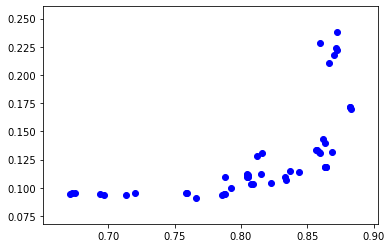

Wall time: 8.32 s


In [1]:
%%time
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import logging
import random
import numpy as np

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

from deap import algorithms, base, benchmarks, creator, tools


# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

def evaluate(vars):

    # for ii, item in enumerate(vars):
    #     vars[ii] = denormalize_max_min(vars[ii], max_x[ii], min_x[ii])

#     # load BL model BNN
#     BL_model = torch.load('BNN_BLmodel.pt')

    max_part_height = 4.2   # maximum part height mm

    # print(vars[2])

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] == 1:
        height = 0.42
    elif vars[2] == 2:
        height = 0.6
    elif vars[2] == 3:
        height = 0.7

    # print(vars)
    num_layers = np.int(max_part_height / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    inp = [] # input to BNN to make predictions
    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2

    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')

    # normalize data
    inp = normalize_max_min(inp, max_x, min_x)

    x_pred = torch.tensor(inp)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(10):
        preds = toolbox.model.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

#     print(means.mean(), total_unc.mean(), vars)
    # if means.mean()>0.7:
    #     print(means.mean(),total_unc.mean(),vars)

    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height**2

    return dimensionless_mean_bl, dimensionless_total_unc_bl

# The constraint is:
# (Nozzle velocity) x (line width) x (layer thickness)  less than/ equal to 24 mm/s3
def feasible(individual):
    """Feasability function for the individual. Returns True if feasible False
    otherwise."""
    
    line_width = 0.8 # in mm
    
    # layer height in mm
    if individual[2] == 1:
        height = 0.42
    elif individual[2] == 2:
        height = 0.6
    elif individual[2] == 3:
        height = 0.7
        
    if individual[1] * line_width * height <= 24:
        print(individual,'true')
        return True
    print(individual,'false')
    return False

IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 1], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.randint, 217, 278)
toolbox.register("attr_speed", random.randint, 26, 44)
toolbox.register("attr_layer", random.randint, 1, 3)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)

# Structure initializers
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# load BL model BNN and evaluate objectives
toolbox.model = torch.load('BNN_BLmodel.pt')
toolbox.register("evaluate", evaluate)

# A penality function can be added to any evaluation function using the DeltaPenality decorator provided in the tools module.
# Delta = [0,1] worst cases
toolbox.decorate("evaluate", tools.DeltaPenality(feasible, [0,1]))

toolbox.register("mate", tools.cxUniform, indpb=0.50)
toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=0.50)

def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
#                         print(child[i])
                        child[i] = max[i]
                    elif child[i] < min[i]:
#                         print(child[i])
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 1], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 1], [278, 44, 3]))

toolbox.register("select", tools.selNSGA2)
# ref_points = tools.uniform_reference_points(nobj=2, p=12)
# toolbox.register("select", tools.selNSGA3WithMemory(ref_points))

toolbox.pop_size = 50
toolbox.max_gen = 2
toolbox.mut_prob = 0.2

def main(toolbox):
    random.seed(64)

    pop = toolbox.population(n=toolbox.pop_size)
    hof = tools.ParetoFront()
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, lambda_=toolbox.pop_size,
                              cxpb=1-toolbox.mut_prob, mutpb=toolbox.mut_prob, ngen=toolbox.max_gen,
                              stats=stats, halloffame=hof, verbose=True)

    return pop, stats, hof


if __name__ == "__main__":
    pop, stats, hof = main(toolbox)

    import matplotlib.pyplot as plt
    import numpy

    front = numpy.array([ind.fitness.values for ind in pop])
    plt.scatter(front[:,0], front[:,1], c="b")
    plt.axis("tight")
    plt.show()


In [2]:
pop

[Individual('d', [228.0, 29.0, 3.0]),
 Individual('d', [242.0, 32.0, 2.0]),
 Individual('d', [234.0, 32.0, 3.0]),
 Individual('d', [232.0, 26.0, 3.0]),
 Individual('d', [238.0, 35.0, 3.0]),
 Individual('d', [249.0, 30.0, 2.0]),
 Individual('d', [234.0, 32.0, 3.0]),
 Individual('d', [234.0, 27.0, 3.0]),
 Individual('d', [249.0, 30.0, 2.0]),
 Individual('d', [238.0, 26.0, 3.0]),
 Individual('d', [259.0, 26.0, 2.0]),
 Individual('d', [220.0, 26.0, 1.0]),
 Individual('d', [247.0, 26.0, 3.0]),
 Individual('d', [234.0, 32.0, 3.0]),
 Individual('d', [231.0, 27.0, 3.0]),
 Individual('d', [238.0, 37.0, 3.0]),
 Individual('d', [249.0, 30.0, 2.0]),
 Individual('d', [250.0, 31.0, 2.0]),
 Individual('d', [242.0, 27.0, 3.0]),
 Individual('d', [220.0, 26.0, 1.0]),
 Individual('d', [244.0, 37.0, 3.0]),
 Individual('d', [247.0, 31.0, 3.0]),
 Individual('d', [236.0, 37.0, 3.0]),
 Individual('d', [256.0, 34.0, 2.0]),
 Individual('d', [259.0, 39.0, 2.0]),
 Individual('d', [247.0, 29.0, 3.0]),
 Individual(